# Crop single cell images in the HPA dataset

This notebook shows an approach to crop images to obtain single-cell level images from the Human Protein Atlas (HPA)-Single Cell Classification competition. Functions and other ideas were used from other Kaggle notebooks listed below. 

## 1 Transform images in the training set to single-cell images
For a single image and using the cell segmentations mask from CellSegmentator we can generate a RGB image for each cell in the image as follows:

1. Segment image using CellSegmentator.
2. Add bounding boxes using cell mask from the first step. 
3. Crop using the bounding boxes.

Repeating this process for all images generates a new dataset containing single-cell level images for each original image. Additionally we should generate a new .csv file containing the new single-cell identifiers and their labels. 

## 2 General comments
In this notebook only the first 10 images in the train set were used to demonstrate how the cropping process works. However the train set is so large it will require more computing power to complete the whole task in a reasonable time. Some image quality evaluation could be implemented, for example removing images that are too small or that only contain a small area of a single cell could be removed. Maybe this is not the most efficient way to complete this task, so any suggestions or comments are always welcome.  


Reference Notebooks:

(1) [HPA_segmentation_and_BBOXES](https://www.kaggle.com/philipjamessullivan/hpa-segmentation-and-bboxes) by philipjamessullivan and acqua.

(2) [Crop images using bounding box](https://www.kaggle.com/whizzkid/crop-images-using-bounding-box) by Ashutosh Chandra.

(3) [pretrained ResNet34 with RGBY (0.460 public LB)](https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb) by Iafoss.




In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings 
import os,gc,cv2
import shutil
import random
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

%matplotlib inline
warnings.filterwarnings('ignore')

# HPA single-cell image segmentation 
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

     / 17 kB 216 kB/ss
     / 131 kB 469 kB/sB/s
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14938 sha256=b7e5e735b0ecae8670aa481f1401171582f35da37e45dfd3a853ab877f627cf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vehvstq/wheels/cd/d8/de/04ad08802d62537f8dffc89b6a7ce0a53c3d29ea6eae522ab1
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=650151885e2bbff0b7435ad7e4d2ff218bb92fb39eb267ef0aa1e55207a08876
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vehvstq/wheels/58/0e/c7/567928a140c7cb2533c59bdc81fded8fe720ea8caad1659d8c
Successfully built hpacellseg pytorch-zoo


In [2]:
# directories 
DIR = '../input/hpa-single-cell-image-classification/'
os.listdir(DIR)
# csv files:
CSV_PATH=os.path.join(DIR,'train.csv') 
# image files:
IMG_FOLDER_PATH=os.path.join(DIR, 'train/')
# create new directories in the  output directories for masks and cropped images
CROPS = './sc_cropped_img_HPA/'
if not os.path.exists(CROPS):
       os.makedirs(CROPS)        
# directory to save dataframe containing new single cell image identifiers and labels
NEW_DF='./train_sc_df.csv'

In [3]:
# read id/label csv to array
id_labels_array=pd.read_csv(CSV_PATH)
# fix labels (convert to arrays)
id_labels_array["Label"]=id_labels_array["Label"].apply(lambda x:list(map(int, x.split("|"))))     
# create list of all ids from the id_labels_array
ids_images=(id_labels_array["ID"]).tolist()
# create dictionary of all unique labels from the id_labels_array
labels=id_labels_array.set_index('ID').T.to_dict('list')
# fix the dictionary format (2d arrays to 1D arrays)
labels = {num: labels[0] for num, labels in labels.items()}

In [4]:
# Define CellSegmentator class
# [source: https://github.com/CellProfiling/HPA-Cell-Segmentation]
#-----------------------------------------------------------

# [1] path to the nuclei model weights:
NUC_MODEL = './nuclei-model.pth'
#-----------------------------------------------------------
# [2] path to the cell model weights:
CELL_MODEL = './cell-model.pth'
#-----------------------------------------------------------
# [3] scale_factor: determines how much the images should be 
# scaled before being fed to the models. For HPA Cell images, 
# a value of 0.25 (default) is good.
#-----------------------------------------------------------
# [4] device: Inform Torch which device to put the model on. 
#Valid  values are ‘cpu’ or ‘cuda’ or pointed cuda device  
# like 'cuda:0’. Defaults to cuda.
#-----------------------------------------------------------
# [5] padding: If True, add some padding before feeding the 
# images to the neural networks. This is not required but 
# can make segmentations, especially cell segmentations,
# more accurate. Defaults to False. Note: If you have issues 
# running the segmentation due to image dimensions, setting 
# padding to True may help.
#-----------------------------------------------------------
# [6] multi_channel_model: If True, use the pretrained 
# three-channel version of the model. Having this set to 
# True gives you better cell segmentations but requires 
# you to give the model endoplasmic reticulum images as 
# part of the cell segmentation. Otherwise, the version 
# trained with only two channels, microtubules and nuclei, 
# will be used. Defaults to True
#-----------------------------------------------------------
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cpu",
    padding=True,
    multi_channel_model=True,
)

Could not find ./nuclei-model.pth. Downloading it now


please compile abn


Could not find ./cell-model.pth. Downloading it now


In [5]:
# functions:

def open_rgby(img_id, img_dir): 
    '''
    Reads individual images
    of different filters (R, G, B, Y)
    and stack them.
    ---------------------------------
    Arguments:
    img_id -- image file identifier
    img_dir -- the path containing all image files
    Returns:
    stacked (RGBY) image '''
    colors=['red','green','blue','yellow']
    flags=cv2.IMREAD_UNCHANGED
    img=[cv2.imread(os.path.join(img_dir, img_id+'_'+color+'.png'), flags).astype(np.float32)/255 for color in colors]
    return np.stack(img, axis=-1)


def generate_single_mask(img_id, img_dir):
    '''
    Computes cell mask for a single image
    using HPA CellSegmentator tool
    ---------------------------------
    Arguments:
    img_id -- image file identifier
    img_dir -- the path containing all image files
    Returns:
    cell_mask as ndarray'''
    path=os.path.join( img_dir + img_id )
    ch_r = Image.open(path+"_red.png")
    ch_y = Image.open(path+"_yellow.png")
    ch_b = Image.open(path+"_blue.png")
    nuc_segmentations = segmentator.pred_nuclei([np.asarray(ch_b)])
    cell_segmentations = segmentator.pred_cells([
                [np.asarray(ch_r)],
                [np.asarray(ch_y)],
                [np.asarray(ch_b)] ])
    cell_nuclei_mask, cell_mask = label_cell(nuc_segmentations[0], cell_segmentations[0])
    cell_mask = np.uint8(cell_mask)
    return cell_mask


def bbox(mask,cell_id):
    '''
    Finds the bounding box for each 
    single cell in an image
    ---------------------------------
    Arguments:
    mask -- cell mask for single image as ndarray
    cell_id -- cell identifier (integer) from HPA CellSegmentator
    Returns:
    bounding-box coordinates as list: xmin, ymin, xmax, ymax'''
    a = np.where(mask == cell_id)
    xmin, ymin, xmax, ymax = np.min(a[1]), np.min(a[0]), np.max(a[1]), np.max(a[0])
    return xmin, ymin, xmax, ymax


def crop_sc_imgs(imgid_list, dtrain, img_dir, out_dir, csv_dir):
    '''
    Crops images to obtain 
    single-cell images
    ---------------------------------
    Arguments:
    imgid_list -- image file identifier
    dtrain -- train set dataframe containing image indentifiers and labels
    img_dir -- the path containing all image files
    out_dir -- path for saving single-cell cropped images
    csv_dir -- path to save new train set dataframe
    Returns:
    stacked (RGBY) images for cells in each image
    new dataframe containing cell image identifiers and their labels
    '''
    new_ids=[]
    new_labels=[]
    for imgid in tqdm(imgid_list):
        img=open_rgby(img_id=imgid, img_dir=img_dir)
        # read image level multi-labels
        df_img=dtrain[ dtrain["ID"]==imgid ]
        cell_label=df_img["Label"].iloc[0]
        # image cell mask
        cell_mask=generate_single_mask(img_id=imgid, img_dir=img_dir)
        cell_mask_flattened=np.ravel(cell_mask)
        cell_ids=set(cell_mask_flattened); cell_ids.remove(0)
        for cell_id in cell_ids:
            cell_img_id=imgid+'_sc_'+str(cell_id)
            new_ids.append(cell_img_id)
            new_labels.append(cell_label)
            xmin, ymin, xmax, ymax = bbox(cell_mask,cell_id)
            new_img=img[ymin:ymax, xmin:xmax]
            new_img=cv2.convertScaleAbs(new_img, alpha=(255.0))
            cv2.imwrite( os.path.join(out_dir+ cell_img_id +'.png'), new_img )
    new_df=pd.DataFrame({'ID': new_ids, 'Label': new_labels })
    new_df.to_csv(csv_dir, index=False)

In [6]:
# reads train set dataframe again
train_df=pd.read_csv(CSV_PATH)
# select only 10 images and use the function
images=ids_images[0:10]
crop_sc_imgs(imgid_list=images, dtrain=train_df, img_dir=IMG_FOLDER_PATH, out_dir=CROPS, csv_dir=NEW_DF)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# checks old and new dataframes
new_train_df=pd.read_csv(NEW_DF)
print( train_df.head(), '\n' )
print( new_train_df.head(), '\n' )

                                     ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0 

                                          ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_sc_1  8|5|0
1  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_sc_2  8|5|0
2  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_sc_3  8|5|0
3  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_sc_4  8|5|0
4  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_sc_5  8|5|0 



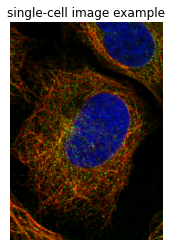

In [8]:
# plot a randomly selected single-cell cropped image
sc_imgs=glob.glob( os.path.join(CROPS + '*.png') )
random_img=random.sample(sc_imgs, 1)[0]
ex_sc_img=cv2.imread(random_img)
plt.imshow(ex_sc_img)
plt.axis('off')
plt.title('single-cell image example')   
plt.show()  